In [1]:
from tensorflow.keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Extracting features using the pretrained convolutional base

In [12]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "C:/Users/R01-PC13/Downloads/Kaggle_orignal/cat_and_dog_small"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                                            directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Defining and training the densely connected classifier

In [13]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])
history = model.fit(train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels))

C:\Users\R01-PC13\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
100/100 [==============================] - 13s 23ms/step - loss: 0.6800 - acc: 0.5962 - val_loss: 0.4355 - val_acc: 0.8470
Epoch 2/30
100/100 [==============================] - 2s 19ms/step - loss: 0.4435 - acc: 0.8109 - val_loss: 0.3573 - val_acc: 0.8720
Epoch 3/30
100/100 [==============================] - 2s 20ms/step - loss: 0.3681 - acc: 0.8412 - val_loss: 0.3337 - val_acc: 0.8590
Epoch 4/30
100/100 [==============================] - 2s 19ms/step - loss: 0.3216 - acc: 0.8662 - val_loss: 0.2965 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 2s 18ms/step - loss: 0.2921 - acc: 0.8838 - val_loss: 0.2796 - val_acc: 0.8960
Epoch 6/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2647 - acc: 0.8843 - val_loss: 0.2695 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2388 - acc: 0.9083 - val_loss: 0.2605 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 2s 21ms/step -

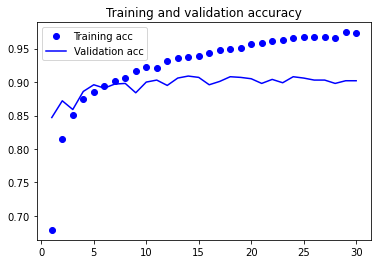

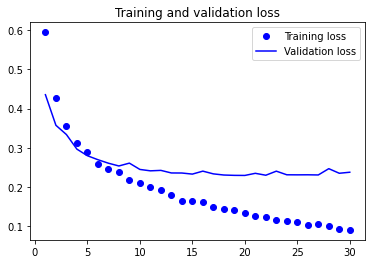

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [16]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Training the model end to end with a frozen convolutional base

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
                    validation_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')
model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=2e-5),
                    metrics=['acc'])


history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50)     





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Freezing all layers up to a specific one

In [27]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-5),
                metrics=['acc'])
history = model.fit_generator(
            train_generator,
            steps_per_epoch=25,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=50)

Epoch 1/10
 9/25 [=========>....................] - ETA: 22s - loss: 0.2091 - acc: 0.9140